# Introduction:

This notebook is to summarize the practical steps of linear regression. I tried to be as generic as possible, but each dataset has its unique characteristics that need extra, or fewer, steps. That said if you notice any missing or extra steps don't hesitate to leave a comment :) 

Let's denote the dependent variable $y$, and the independent variables (features) $x ~ (x_1, x_2\dots x_n)$. Then list the project pipeline as follows:
1. Ask the right question
2. Read the data: 
 - Examine data types; look for any missing values, outliers, imbalance (across $y$ and $x$) in the set
 - Scatter plot $y,x$: this will help spot the relationship between them 
 - Plot histograms $y,x$: look for normality. This will help you know what to expect! 
3. Based on the spotted relationship, decide which model to use (linear, log-linear, quadratic..etc). Try to answer the following questions:
 - What value/s can $y$ take (positive, negative, or zero)?
 - What should the signs of the coefficients be (positive, negative)?
4. Build the model and examine results:
 - Are the coefficients statistically significant?
 - Do they have the signs you'd expected?
 - Make sense of the coefficients irrespective of their significance. Adjust if needed. **, For example,**: ask the question does the sign/value/p-value of a coefficient make economic sense?
5. Now that you've built the model and adjusted parameters, run a goodness-of-fit to make sure the model doesn't violate any of the assumptions of linear regressions (4.1 for details) :
 - Linearity
 - Independence (of $x$): is there a multicollinearity
 - Homoscadasticity of $\epsilon$: Breusch–Pagan test.
 - No autocorrelation of $\epsilon$: Durbin-Watson test 
 - Normality of $\epsilon$: Shapiro-Wilk Test for normality, Q-Q plot, histogram 
6. If the model is invalid, try another formula and repeat step 4. 
7. Make sure the residuals are 1) normally distributed 2) have constant variance 3) independent 4) not serially correlated.
8. Predict values and calculate their intervals. Try to set aside a slice of your data to test with, or we can mock-up test data if possible! 
9. Make sure the predictions make economic sense 
 

# 1. Ask the Right Question:
   
The first and most important step in data analysis is to ask the right question. Here, the question is: is there a linear relationship between (Height, Gender) and Weight. If Yes, build a model to reference it, validate this model, interpret results and make predictions.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import probplot
from sklearn.metrics import r2_score
import statsmodels.formula.api as smf
from statsmodels.stats import diagnostic

plt.style.use('default')
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

np.random.seed(123)
%matplotlib inline

# 2. Read & Clean the Data:
The second step is collecting data. Here we're using a simple Bivariate dataset that contains Weights - in lbs- and Heights -in inches- of 10,000 observations. They represent Male and Female adults that we presume were taken randomly from the population!

In [2]:
path = '~/workspace/RegressionTests/lib/data/weight-height.csv'
df = pd.read_csv(path)
df.head()

,Gender,Height,Weight
0,Male,73.847017,241.893563
1,Male,68.781904,162.310473
2,Male,74.110105,212.740856
3,Male,71.730978,220.042470
4,Male,69.881796,206.349801


### 2.1 Missing Values (N/A):
Examine the data for any missing values in $x, y$. If there is any, you can either drop the missing record or fill it with its closest match

In [3]:
print(df.isna().sum())

Gender    0
Height    0
Weight    0
dtype: int64


**Conclusion:** No N/As to worry about.

### 2.2 Outliers

Sometimes outliers are bad data that you must get rid of, but sometimes they're Michael Jordan or Shaquille O'Neal and you must keep. Either way, outliers must be identified before you decide how to deal with them.  
The two most common definitions of outliers are: 
1. Observations that are more than 3 standard deviations away from the mean.
2. Observations that are more than 1.5 * Inter-Quartile-Range (IQR) below/above the 25th/75th percentiles (ends of the boxplot).

Current data contains one continuous and one categorical (discrete) variable. So a simple boxplot should reveal any outliers.  

**More on outliers detection**   
The most common techniques used to identify outliers by data types is:  
- Univariate data -> boxplot. outside of 1.5 times the inter-quartile range is an outlier.  
- Bivariate -> scatterplot with confidence ellipse. outside of, say, 95% confidence ellipse is an outlier.  
- Multivariate -> Mahalanobis D2 distance   

Once defined, mark those observations as outliers. Then run a logistic regression to see if there are any systematic patterns.  

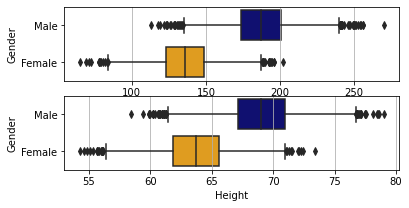

In [4]:
# Outliers: 
palette=['navy','orange']
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(6,3))
ax1.grid()
# ax1.boxplot(data=df, x=['Weight'])
sns.boxplot(x=df.Weight, y=df.Gender, ax=ax1, palette=palette)
ax2.grid()
sns.boxplot(x=df.Height, y=df.Gender, ax=ax2, palette=palette);

**Conclusion** 
There are visible outliers that meet the definition, but I don't think I should remove them because I see no reason why a 270 lbs male or a 55-inch female should be excluded! 

### 2.3 Balanced

In general, having balanced data generates higher accuracy models. This is true for all regression types and machine learning algorithms.  

In [5]:
# 3. Distribution across genders is perfect
pd.value_counts(df.Gender)

Male      5000
Female    5000
Name: Gender, dtype: int64

**Conclusion** the data is split equally between Males and females, which is great!  

No further action is needed.
### 2.4 Scatter plot x,y

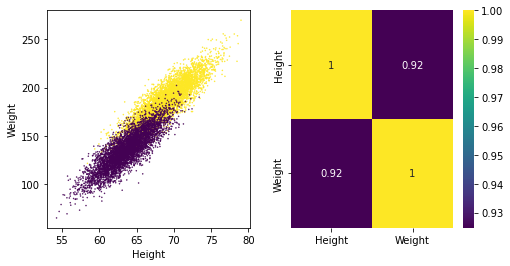

In [6]:
fig,ax = plt.subplots(1,2, figsize=(8,4))
ax[0].scatter(df.Height, df.Weight, c=df.Gender=='Male',marker='.',s=1)
ax[0].set_xlabel('Height')
ax[0].set_ylabel('Weight')
sns.heatmap(df.corr(), annot=True, ax=ax[1],cmap='viridis');

### 2.5 Distribution of Variables (Optional)
The dependent and/or independent variables don't need to be Normal distributed. Yet, if their distributions are extremely off normal, it's difficult to fit a line that results in normal errors. Which is one of the assumptions of linear regression 3.1.6. 
I usually check the distribution of all variables upfront to know what to expect. This is an optional but helpful step.  

The easiest way to do that in practice is to visualize the distribution using a histogram (across categories):

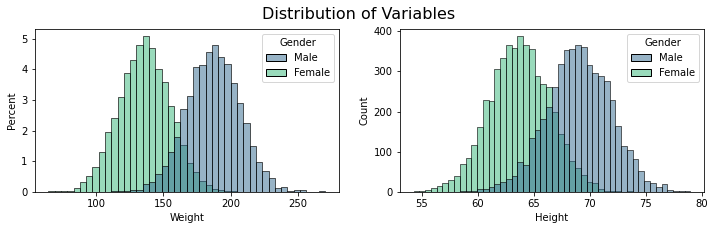

In [7]:
fig,ax = plt.subplots(1,2,figsize=(12,3))
fig.suptitle('Distribution of Variables', fontsize=16)
sns.histplot(data=df, x='Weight', hue='Gender', ax=ax[0], stat='percent', palette='viridis')
sns.histplot(data=df, x='Height', hue='Gender',ax=ax[1], palette='viridis');

Seems like both variables are normally distributed. This will make our life easier when investigating some of the typical problems of linear regressions. 

## 3. Analyzing the Data

This step should answer the question asked in step (1). i.e. is there a linear relationship between the dependent and independent variables?  That said, let's list the assumptions of linear regression:
### 3.1 Assumptions of a Linear Regression

1. There is a linear relationship between dependent and independent variables
2. The independent variables are not random, and there is no exact linear relationship between them. (no multicollinearity)
3. The expected value of error term is zero $E(\epsilon | x_i)=0$
4. The variance of the error term is constant for all observations (i.e. $E(\epsilon^2_i)=\sigma_{\epsilon}^2$ (no heteroscedasticity)
5. The error term of one observation is not correlated with that of another (no serial correlation)
6. The error term is normally distributed

We are going to test each of these assumptions after regressing the data  


### 3.2 Pre-Processing
#### 3.2.1 Split the Data

It's standard practice to split the data into training and test sets to see how the model behaves when presented with data it hasn't seen. I'm going to use pandas to do this. 

Another, very common way to do it is by using`train_test_split` from `sklearn.model_selection`, but I prefer pandas. As it retains both sets as DataFrames. This will make the regression outcome much more user-friendly!  


In [8]:
# Split the data to train and test using pandas

df_test = df.sample(frac=0.3)
df_train = pd.merge(df, df_test, how='outer', indicator=True).query('_merge =="left_only"').drop(columns=['_merge'])
print(f'Size of training set:{len(df_train)}, size of test set: {len(df_test)}\n')

Size of training set:7000, size of test set: 3000



#### 3.2.2 Balance Re-Check

To make sure splitting the data didn't affect the balance of observations:

In [9]:
print("Gender count across Train Set:\n",pd.value_counts(df_train.Gender))

Gender count across Train Set:
 Male      3515
Female    3485
Name: Gender, dtype: int64


### 3.3 OLS regression model

In [10]:
# Ordinary Least Square (OLS) regression
ols = smf.ols(formula="Weight ~ C(Gender) + Height", data=df_train)
res = ols.fit(cov_type='nonrobust')
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 Weight   R-squared:                       0.901
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                 3.184e+04
Date:                Fri, 19 Nov 2021   Prob (F-statistic):               0.00
Time:                        11:18:04   Log-Likelihood:                -26073.
No. Observations:                7000   AIC:                         5.215e+04
Df Residuals:                    6997   BIC:                         5.217e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept          -244.1529      2.77

## 4. Interpreting Regression Results

Adj. R-Squared value at 0.902 and Prob(F-statistic) at 3.2e+4, tell that the model is doing a good job explaining the variability in the independent variable. The coefficients have high t-values and zero associated p-values indicating statistical significance.  


### 4.1 Is the Model Valid?

To answer this question we need to make sure the model does not violate any of the assumptions in 4.1, So let's group them and sort them from most to least serious.  


### 4.1.1 Violations of linearity (Extremely Serious)

**First:** Check the correlation between dependent and independent variables. The table below shows a strong positive association between Height and Weight across Genders, which supports linearity in our case (be careful when using correlation in higher dimensions as it could be misleading)   

**Second:**  
Plot predicted vs. observed: the points should be symmetrically distributed around a diagonal line (figure 1)  
Plot predicted vs. residuals: the points should be symmetrically distributed around a horizontal line (figure 2)  

In [11]:
#Correlation between Hieght and Weight across Genders
print("Corrolation table:\n", df_train.groupby('Gender').corr().Height.to_frame().loc[(slice(None),["Weight"]),])

Corrolation table:
                  Height
Gender                 
Female Weight  0.850123
Male   Weight  0.857125


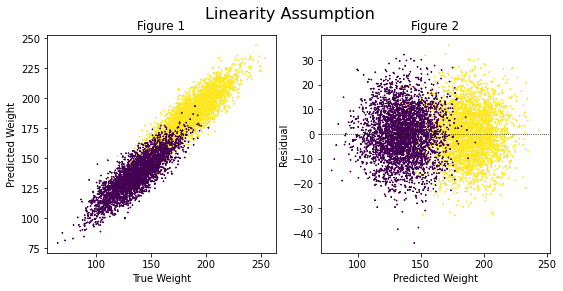

In [12]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(9,4), squeeze=True)
fig.suptitle("Linearity Assumption", fontsize=16)
ax1.scatter(x=df_train.Weight, y=res.predict(), c=df_train.Gender=='Male', s=0.65, marker='x')
ax1.set_title('Figure 1')
ax1.set_xlabel('True Weight')
ax1.set_ylabel('Predicted Weight')
ax2.scatter(x=res.predict(), y= res.resid, c=df_train.Gender=='Male', s=0.65, marker='x')
ax2.set_title('Figure 2')
ax2.set_xlabel('Predicted Weight')
ax2.set_ylabel('Residual')
ax2.axhline(0,lw=0.8,c='k',ls=':')
plt.show()

Our model appears to be linear.

### 4.1.2 Violation of Independence (Multicollinearity):
"The independent variables are not random and there is no exact linear relationship between them".  
Typically spotted when t-tests indicate non of the individual coefficients is significant **while** R-squared and F-statistics are high. We don't have this here.  
It can also be present if the **Condition Number** is large, which it is here, but we can ignore this since we have only one continuous variable

### 4.1.3 Violations of Homoscedasticity:
Heteroskedasticity occurs when the variance of the residuals is not constant across observations. There are two methods to detect heteroskedasticity: examining scatter plots of the residuals
and using the Breusch-Pagan chi-square $\chi^2$ test.

Visually, scatter plot **residuals vs. predicted** and **residuals vs. one or more independent** variable. And look for patterns where residuals grow/shrink as a function of predicted values (or time in case of time series)  
We've already plotted residuals vs predicted in figure (1) and it seems consistent, so lets look at residuals vs independent variables Height/Gender 

In [13]:
#Breusch_Pagan x^2 tests the hypothesis that the residual variance does NOT depend on the variables in x 
# It also assums the data has a constant column. So I'm gonna add one 
# The test cannot read categorical varaiabls without factorization
df_train['Const'] = 1
df_train['G'],_ = df_train.Gender.factorize()

_,_,F,p_value = diagnostic.het_breuschpagan(res.resid, df_train[['Height','G','Const']], robust=False)
print(f"Breusch_Pagan: F-statistic {F}, P-value:{p_value}")

Breusch_Pagan: F-statistic 0.18228966317293654, P-value:0.8333638693651717


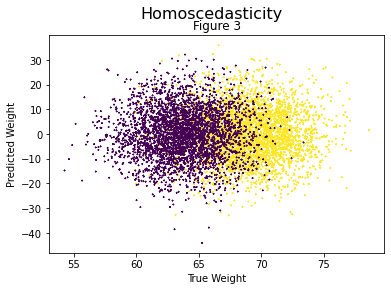

In [14]:
fig,ax1 = plt.subplots(1,1,figsize=(6,4), squeeze=True)
fig.suptitle("Homoscedasticity", fontsize=16)
ax1.scatter(x=df_train.Height, y=res.resid, c=df_train.Gender=='Male', s=1, marker='x')
ax1.set_title('Figure 3')
ax1.set_xlabel('True Weight')
ax1.set_ylabel('Predicted Weight')
plt.show()

**Conclusion** Breusch_Pagan F-statistic is very small and its p-value is > 0.05. So we fail to reject the null hypothesis that the residuals do NOT depend on x. 
The scatter plot also confirms this in the absence of any patterns. Therefore no violation of this assumption

### 4.1.4 Serial Correlation:
Also known as autocorrelation, when the residuals are correlated with one another. This is more of a problem in time series data.  
To diagnose it we look at **Durbin-Watson** number from regression results DW = 2.014. Since it is in the range of (1.5, 2.5) then there is no serial correlation to worry about.

### 4.1.5 Normality of Error Terms:
If error terms are **NOT** normally distributed it'll cause problems when t-testing the coefficients because standard error is no longer reliable. This will affect the confidence intervals of model predictions.  
The easiest way to diagnose normality is to plot a histogram of residuals or a Q-Q plot (from `scipy.stats.probplot`).  

*Note: In `statsmodels` regression summary, many of the outputs address the normality of residuals $\epsilon$: Omnibus, Skew, Kurtosis, Jarque-Bera (details at the end of this notebook)*

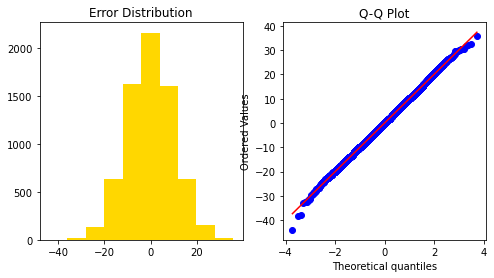

In [15]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(8,4))
ax1.hist(res.resid, color='gold')
ax1.set_title('Error Distribution')
probplot(res.resid, plot=ax2)
ax2.set_title('Q-Q Plot');

**Conclusion** error terms appear to be normally distributed 
### 5.1 Prediction


In [16]:
y_test_pred = res.predict(exog=df_test)
test_rsquare= r2_score(df_test.Weight, y_test_pred)
print(f"Test R-squared:{test_rsquare:.3f} ")

Test R-squared:0.907 


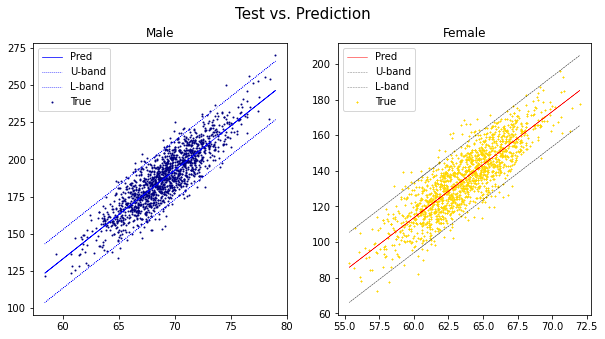

In [17]:
male_mask = np.where(df_test.Gender=='Male', True, False)
test_pred = res.get_prediction(df_test)
test_summary = test_pred.summary_frame()
labels = ['True','Pred','U-band','L-band']
fig,(axm, axf) = plt.subplots(1,2,figsize=(10,5))
fig.suptitle('Test vs. Prediction', fontsize=15)
axm.scatter(df_test[male_mask].Height,df_test[male_mask].Weight, label=labels[0], marker='o',s=1, color='navy')
axm.plot(df_test[male_mask].Height, test_summary[male_mask]['mean'], color='b', label=labels[1],lw=0.75)
axm.plot(df_test[male_mask].Height, test_summary[male_mask]['obs_ci_lower'], 'b:', label=labels[2],lw=0.75)
axm.plot(df_test[male_mask].Height, test_summary[male_mask]['obs_ci_upper'], 'b:', label=labels[3],lw=0.75)
axm.set_title('Male')

axf.scatter(df_test[~male_mask].Height,df_test[~male_mask].Weight, s=1,marker='x',color='gold',label=labels[0])
axf.plot(df_test[~male_mask].Height, test_summary[~male_mask]['mean'], color='red', label=labels[1],lw=0.5)
axf.plot(df_test[~male_mask].Height, test_summary[~male_mask]['obs_ci_lower'], 'k--', label=labels[2],lw=0.5, alpha=0.5)
axf.plot(df_test[~male_mask].Height, test_summary[~male_mask]['obs_ci_upper'], 'k--', label=labels[3],lw=0.5, alpha=0.5)
axf.set_title('Female')
axf.legend()
axm.legend();


# Appendex
Here are some important definitions and explanations of regression outputs often used in statistical analysis.

### Bias of Estimator
Bias is a measure of the difference between the estimator's expected and true values. As such, a biased estimator is one with coefficients that are very different from the true values 

### Efficiency of Estimator
An efficient estimator is the 'best possible' estimator of the parameter of interest that minimizes the loss function. In linear regression, it's the parameter that provides the smallest variance.

#### 7.1 R-squared
R-squared/Adj.R-squared: 90.4% of the variability in the dependent variable is explained by the independent variables. This is high enough for the training set, but let's see how well the model deals with data it hasn't seen (test_set)
Test R-squared at 90.5% is as high as train R-squared, which means the model generalizes well


#### 7.2 F-statistic|Prob(F)
It tests how well the independent variables as a group explain the variations of the dependent variable (i.e. tests the null hypothesis $H_0: \beta_1=\beta_2=\dots \beta_n=0$   
P-value of F-statistic, or the probability of type I error (observation happening giving the null hypothesis is true)  
In this case, F-statistic is very large and Prob(F) is zero, which is great!  

#### 7.3 AIC:
The Akaike Information Criterion (AIC) measures overfit. It rewards the model for goodness-of-fit and penalizes it if it became overly complicated.  
AIC is useful when comparing models but very hard to interpret standalone!  

#### 7.4 Omnibus/Prob(Omnibus):
Tests the normality of the residuals. We hope to see a value close to zero for the Omnibus number and a value close to one for the Prob (Omnibus).
**Omnibus: the closer to zero the better***  
**Prob(Omnibus): The closer to one the better***  

In this case, Omnibus is relatively high and the Prob (Omnibus) is relatively low so the data is far from normal. 

#### 7.5 Skew 
Measures data symmetry. We want to see something close to zero, indicating the residual distribution is normal. Note that this value also drives the Omnibus.  
**The closer to zero the better***   

#### 7.6 Kurtosis
A measure of peakiness, or data curvature. Higher peaks lead to greater Kurtosis, and in the case of residuals, a greater Kurtosis means tighter clustering around zero, which implies a better model with few outliers.  
**The higher the better**  

#### 7.7 Durbin-Watson
Tests for serial correlation. A value between 1.5 and 2.5 means there is no serial correlation. In this case, the number is within the acceptable range.  

#### 7.8 Jarque-Bera (JB)/Prob(JB)
Like the Omnibus test, it measures both skewness and kurtosis. We hope to see in this test confirmation of the Omnibus test.   

#### 7.9 Condition Number
Measures the sensitivity of a function's output as compared to its input. When we have multicollinearity, we can expect much higher fluctuations to small changes in the data, hence, we hope to see a relatively small number, something below 30.  
**The smaller below 30 the better**


Good reading on regression violations and how to correct them:  
https://people.duke.edu/~rnau/testing.htm

#### 7.10 Outliers

The below code is another way to identify outliers using a built-in function in `statsmodels` library. It has many options to calculate them. That said, I still don't think there is a need to exclude any observation from this particular dataset

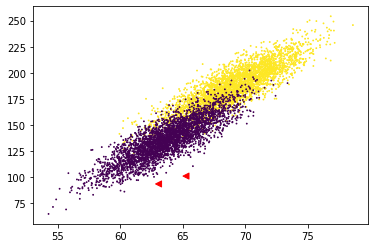

In [18]:
"""
Outlier detection methods:
- 'bonferroni` : one-step correction
- `sidak` : one-step correction
- `holm-sidak` :
- `holm` :
- `simes-hochberg` :
- `hommel` :
- `fdr_bh` : Benjamini/Hochberg
- `fdr_by` : Benjamini/Yekutieli
"""
outliers = res.outlier_test('bonf')
outidx = outliers[outliers.iloc[:,-1] < 0.99].index
outliers.loc[outidx]

fig= plt.figure(figsize=(6,4))
plt.scatter(df_train.Height, df_train.Weight, c=df_train.Gender.values=='Male', s=0.7)
plt.scatter(df_train.loc[outidx].Height, df_train.loc[outidx].Weight, c=df_train.loc[outidx].Gender.values=='Male', marker='<',cmap='flag')
plt.show()